# Fitting Mean Monthly sunspot number.

In this notebook I will use a different data set, which has already been preprocessed to produce the *mean monthly sunspot number*, and perform a GP on that.

The **advantage** of using this dataset is that it is smaller and goes back to 1749.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l_1^2} - \frac{\sin^2}{l^2_2}{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [11]:
df = pd.read_csv('../Data/Sunspots.csv') # importing data for SVG polyorder = 1
x = ((df['Date']).values)
date = pd.to_datetime(x, format="%Y/%m/%d")
y = (df['Monthly Mean Total Sunspot Number']).values + 1e-100
df.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


## Converting datetime to date in fraction of year

(Necessary for GP)

In [13]:
from datetime import datetime as dt
import time

In [14]:
def toYearFraction(dates):
    new_dates = []
    for date in dates:
        Year = date.year
        month = date.month
        days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
        day = date.day
        new_dates.append(Year + day/365.25 + sum(days_in_month[:month-1])/365.25)
    
    return new_dates

In [15]:
X = np.array(toYearFraction(date))[:,None]

X

array([[1749.08487337],
       [1749.1615332 ],
       [1749.24640657],
       ...,
       [2020.91444216],
       [2020.99931554],
       [2021.08487337]])

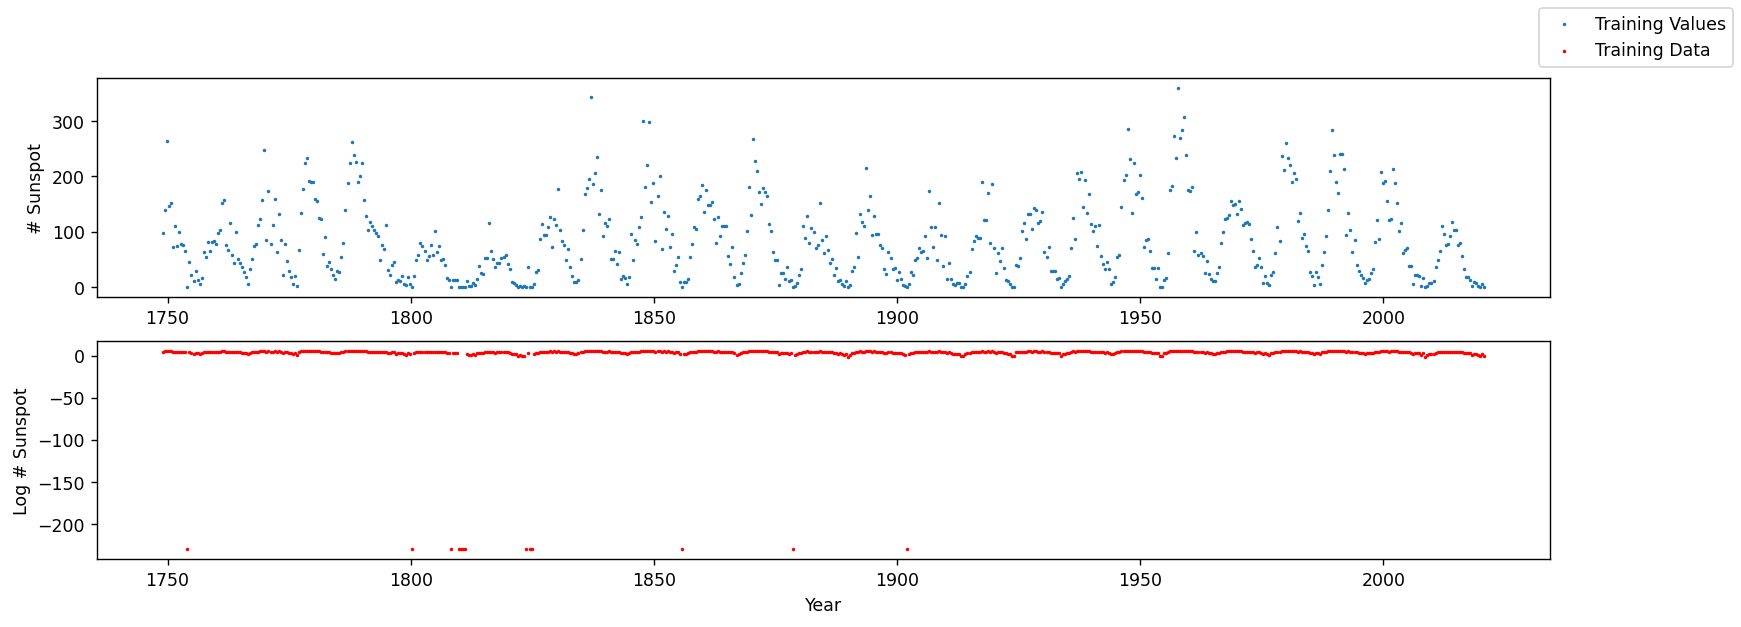

In [16]:
training_values = X[::5], y[::5]
# Note: changed from using random values to using
# every 100 values --> want to get the best fitting 

training_data = training_values[0], np.log(training_values[1])  
# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

In [ ]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return tt.log(self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset)

# Define the Gaussian Process
with pm.Model() as model:
    ''' Change the priors '''
    # Define the phase of the sinusoidal mean
    phase = pm.Beta('phase', 2, 2) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Normal('amplitude', 150, 100) # ~ 150
     
    # Define the offset of the sinusoidal mean
    offset = pm.Gamma('offset', 7.5, 1) # ~20
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('period', 11, 1)
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Gamma('Length Scale 1', 7.5, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Gamma('Length Scale 2', 7.5, 1)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Beta('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, period, offset, amplitude, phase]


The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

**Update:** I have created a custom mean function using *theano*. This mean function is sinusoidal, as opposed to the constant one which was being used previously. I have done this because I don't want my GP to tend to a constand value when it gets too far from the previous data point, as we expect the solar cycle to retain its general sinusoidal shape.

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);
#plt.savefig('gp post.png'); 

#### Comment on plot:

For the latest run-through I have set a separate parameter for the period of the sinusoidal mean (as opposed to the 11 year period previously attempted). As we can see from the posteriors, this parameter has 'messed up' the smooth distributions we had before, and the value for period has many different peaks. 

I still believe that the correct period in the sinusoidal mean should be ~ 11 years, but for the posterior of *period1* shows something very different and needs exploring further.

In [ ]:
X_new = np.linspace(1800, 2075, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

In [ ]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2075)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

#### Comment on plot:

Here we have used a ***quasi-periodic kernel*** consisting of only 200 data points. The GP does a very good job of modelling the data given the sparsity of data, however there is a recurrent issue with our parameter *length_scale1*, which is far too small and refuses to converge on anything else. This results in new predictions which do not show the same periodic behaivour, as the knowledge of the model essentially dies after that time.

**Edit**: Previously the GP was done using the 'training_values', but to ensure positive definiteness I have first taken the logarithm of the y-values, performed the GP, and then returned them back to standard sunspot number. As a result, the values for $A$, $\mu$ and $\sigma$ are all *logarithmic* values. This has improved the predictions made by the GP, as all predictions are plausible (as there are no negative sunspot numbers predicted).

**Edit 2**: Sinusoidal mean allows the future predictions to look more in line with our expectations, but we must not ignore the fact that these future predictions are simply the mean function. Therefore, we could argue that the GP is unable to make any reasonable predictions.


# Predicting validation dataset

## Data Preprocessing

In [ ]:
limit = 65000 # training with the first 70k datapoints
skips = 140 # 2 data point per 5 luna cycle

train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## GP Regression

In [ ]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return tt.log(self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset)

# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the phase of the sinusoidal mean
    phase = pm.Normal('phase', 0.55, 0.05) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Normal('amplitude', 60, 20) # ~ 150
     
    # Define the offset of the sinusoidal mean
    offset = pm.Normal('offset', 15, 1) # ~20
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('period', 10.8, 0.2)
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Gamma('Length Scale 1', 7.5, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Normal('Length Scale 2', 11, 1)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Gamma('$\sigma$', 1, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)
    
    mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model

    tr = pm.sample(return_inferencedata=True) 

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);
#plt.savefig('gp post.png'); 

print(mp)

#### Comment on plot:

Here we have set very large prior distributions (except for period), in the hope that the sampling will converge on an optimal value, rather than using a narrow one (such as a normal distribution with small $\sigma$). This is why are priors are very wide, however the values are a much better fit, as we will see below.

In [ ]:
X_new = np.linspace(1818, 2025, 500)[:, None]
with model:
    fnew = gp.conditional("f_new1", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new1"])

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_new1'], samples=1000)

In [ ]:
from pymc3.gp.util import plot_gp_dist

mmu, var = np.exp(gp.predict(X_new, point=mp, diag=True))
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(14, 5))
#plt.style.use('dark_background')
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new1']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")

#plt.plot(2009.635*np.ones(5), np.linspace(0,400,5), 'g--', label='End of training')
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

# draw plot
fig = plt.figure(figsize=(14, 5))
mu = np.exp(np.mean(ppc['f_new1'], axis=0))
std = np.exp(np.std(ppc['f_new1'], axis=0))

plt.plot(X, y, color="black", label="All Data")
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X_new, mu, color='darkblue', label='Mean Prediction')
#plt.plot(X_new, mmu, color='tab:green', label='Mean Prediction MAP')
plt.fill_between(X_new.flatten(), mu-1.96*std, mu+1.96*std, alpha=1, label='95% CI', color='r')
#plt.fill_between(X_new.flatten(), mmu-1.96*sd, mmu+1.96*sd, alpha=1, label='95% CI', color='g')
plt.legend();

#print(std)

### Comment on plot:

Here we have performed the same GP as before, but now we have given the model 70,000 training values, and we ask it to predict the final few thousand points.

As we can see from the blue GP after we have finished training, the GP is unable to correctly predict what the values would be for sunspot number, the mode is smaller than the actual sunspot number recoreded. This seems to come from the problem with the mean function, as the mean's amplitude is still far too small.

**Edit**: For the latest run, I have used the parameters from the initial GP which takes all the data into account (**this is cheating**), just to see how well the GP performs. The figure above shows predictions which are generally closer to the actual values, however as we can see from the sampling there is still a huge uncertainty as to what the amplitude of the cycles are.

**Edit 2**: I have revisited the mean function and optimised that, as well as changing the priors to encompass a much wider range, so that the sampling has a better chance of finding the ideal parameters. This is the *best* run so far, and seems to predict the minima of the cycles, which has been a challenge for previous kernels.

In [ ]:
''' Saving the Data '''
# Samples Data
X_df = pd.DataFrame(X_new, columns=['X_new'])
y_df = pd.DataFrame(ppc['f_new'].T)
df_samples = pd.concat([X_df, y_df], axis=1)    
df_samples.tail()

#df_samples.to_csv('../Data/GP Modelling Data/GP_df2.csv', index=False)

## Plotting the covariance function

## Finding $\sigma$ & *corr* for Taylor Diagram

In [ ]:
X_new = validation_data[0] # just looking at the validation set
with model:
    fnew = gp.conditional("f_taylor", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_taylor"])

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_taylor'], samples=1000)

In [ ]:
# MAP predictions
map_mu, var = np.exp(gp.predict(X_new, point=mp, diag=True))
map_std = np.sqrt(var)

# Sampling predictions
mu = np.exp(np.mean(ppc['f_taylor'], axis=0))
std = np.exp(np.std(ppc['f_taylor'], axis=0))

In [ ]:
observed = np.exp(validation_data[1])
predicted = mu

# Standard Deviation
std = np.std(observed - predicted) # std
normalised_std = np.array(std / np.mean(observed))

# Correlation
correlation = np.array(np.corrcoef(observed, predicted)[0, 1])

print(f'The normalised standard deviation is {normalised_std:.3f}, and the correlation is {correlation:.3f}.')

In [ ]:
''' Saving the Data '''
data = {"Metric": ["Standard Deviation (Normalised)", "Correlation Coefficient"], "Value": [normalised_std, correlation]}
df = pd.DataFrame(data)
df.to_csv("../Data/Taylor Diagram Data/GP_taylor.csv", index=False)